   # This code plots mov_std_IVM_ion_density + GOLD

Found 348 files in the directory.
UT time: 2021-10-11 23:13:46.415103
Longitude at UT 2021-10-11T23:10:00: 293.2412414550781
UT time: 2021-10-11 23:30:00.406896
Longitude at UT 2021-10-11T23:30:00: 345.5926818847656


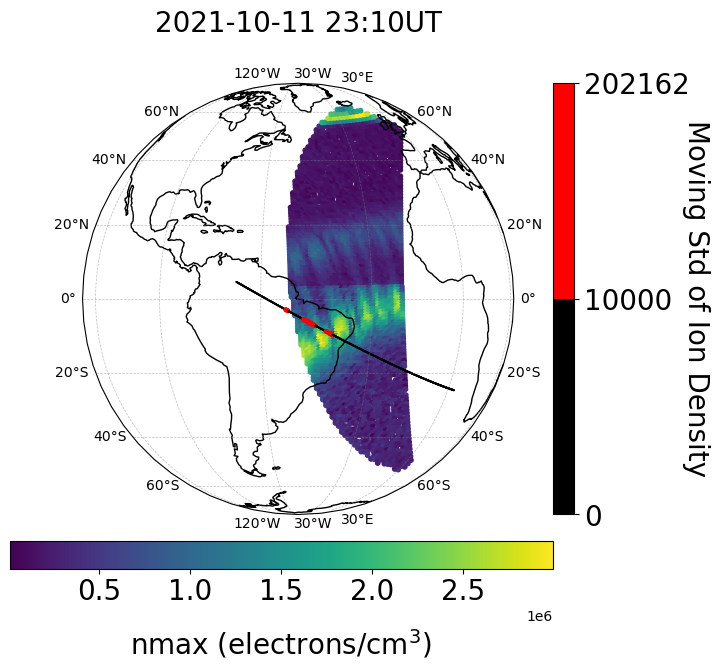

In [2]:
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from datetime import datetime
from netCDF4 import Dataset

# Font sizes
title_font_size = 20
subtitle_font_size = 20
axis_label_font_size = 20
tick_label_font_size = 20


# Function to load data from NetCDF files (IVM Data) with time range filtering
def load_data(file_path, start_time=None, end_time=None):
    try:
        with Dataset(file_path, 'r') as ncfile:
            vars_to_extract = [
                'ICON_L27_Ion_Density',
                'ICON_L27_UTC_Time',
                'ICON_L27_Latitude',
                'ICON_L27_Longitude',
                'ICON_L27_Solar_Local_Time'
            ]
            # Create a dictionary to hold the data
            data = {var: ncfile.variables[var][:] for var in vars_to_extract}

            # Convert the dictionary to a pandas DataFrame
            df = pd.DataFrame(data)

            # Check if the data is bytes and decode, otherwise convert directly to string
            utc_time_data = df['ICON_L27_UTC_Time']
            if isinstance(utc_time_data[0], bytes):
                utc_time_strings = [x.decode('utf-8') for x in utc_time_data]
            else:
                utc_time_strings = [str(x) for x in utc_time_data]

            # Replace 'Z' and 'T' with appropriate characters for datetime parsing
            df['ICON_L27_UTC_Time'] = pd.to_datetime(utc_time_strings).tz_localize(None)

            # Filter by the provided time range if start_time and end_time are specified
            if start_time and end_time:
                # Ensure that start_time and end_time are also Timestamp objects
                start_time = pd.to_datetime(start_time).tz_localize(None)
                end_time = pd.to_datetime(end_time).tz_localize(None)
                df = df[(df['ICON_L27_UTC_Time'] >= start_time) & (df['ICON_L27_UTC_Time'] <= end_time)]

            return df

    except Exception as e:
        print(f"An error occurred while processing the file {file_path}: {e}")
        return None


# Directory where the NetCDF files are stored (IVM Data)
directory_path = "/Users/gildagonzalez/Documents/Datos/ICON DATA/2021/"
file_paths = glob.glob(f'{directory_path}**/*.nc', recursive=True)

# Print the number of files found
print(f"Found {len(file_paths)} files in the directory.")

# Creating a custom colormap with discrete colors (for the Moving Std)
colors = ['black', 'red']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=2)
marker_choice = '.'

# Function to plot data for a range of dates and solar local times (for IVM data)
def plot_data_for_range(ax, start_date, end_date, solar_local_time_lower, solar_local_time_upper, specific_ut_times, start_time=None, end_time=None):
    longitudes_at_times = []
    times_at_longitudes = []
    
    for file_path in file_paths:
        file_date_str = os.path.basename(file_path).split('_')[3]
        file_date = pd.Timestamp(file_date_str).date()

        if file_date < start_date or file_date > end_date:
            continue

        df = load_data(file_path, start_time, end_time)
        if df is not None and not df.empty:
            df_filtered = df[
                (df['ICON_L27_Solar_Local_Time'] >= solar_local_time_lower) & 
                (df['ICON_L27_Solar_Local_Time'] <= solar_local_time_upper)
            ].copy()

            if not df_filtered.empty:
                window_size =3
                df_filtered['Moving_Std_ICON_L27_Ion_Density'] = df_filtered['ICON_L27_Ion_Density'].rolling(window=window_size, min_periods=1).std()
                
                # Loop through each specific UT time to get the corresponding longitude
                for specific_ut_time in specific_ut_times:
                    # Convert the string to a pandas Timestamp object
                    specific_ut_time_obj = pd.to_datetime(specific_ut_time)
                    # Find the absolute difference between each time and the desired one
                    differences = np.abs(df_filtered['ICON_L27_UTC_Time'] - specific_ut_time_obj)
                    # Find the index of the smallest difference
                    idx_closest_time = differences.argmin()
                    # Retrieve the longitude at the closest time
                    closest_longitude = df_filtered.iloc[idx_closest_time]['ICON_L27_Longitude']
                    # Append the found longitude and the time to the list
                    times_at_longitudes.append((closest_longitude, specific_ut_time))
                    # Get the closest UT value for verification
                    closest_time = df_filtered.iloc[idx_closest_time]['ICON_L27_UTC_Time']
                    # Get the corresponding longitude
                    longitude_at_specific_ut = df_filtered.iloc[idx_closest_time]['ICON_L27_Longitude']
                    # Append the result to your list
                    longitudes_at_times.append((specific_ut_time, longitude_at_specific_ut))
                    # Print the information for verification
                    print(f"UT time: {closest_time}")
                    print(f"Longitude at UT {specific_ut_time}: {longitude_at_specific_ut}")


            # Outside the loop, set the title and subtitle
            #if not df_filtered.empty:
                #ax.set_title(f'GOLD nmax for {time_string}', pad=20)
                # Construct the subtitle with both UT times at the specified longitudes
                #subtitle = ' | '.join([f'UT at {lon}° Longitude: {time}' for lon, time in times_at_longitudes])
                #plt.suptitle(subtitle, fontsize=10, y=0.95)  # Adjust y as needed

                
            # Define the condition for blue and red
            is_blue = df_filtered['Moving_Std_ICON_L27_Ion_Density'] <= 10000

            # Define sizes based on the condition: blue gets a smaller size than red
            sizes = np.where(is_blue, 0.5, 20)  # here 0.5 is for blue, 20 for red
            
            # Ensure the data is finite and remove any potential NaN or infinite values before finding the max
            finite_vals = df_filtered['Moving_Std_ICON_L27_Ion_Density'][np.isfinite(df_filtered['Moving_Std_ICON_L27_Ion_Density'])]
            max_val = np.max(finite_vals) if not finite_vals.empty else 0

            # Define the normalization for colormap based on data boundaries
            boundaries = [0, 10000, max_val]
            boundaries.sort()  # Sort the boundaries to ensure they are monotonically increasing
            norm = BoundaryNorm(boundaries, cmap.N)

            scatter = ax.scatter(
                df_filtered['ICON_L27_Longitude'], df_filtered['ICON_L27_Latitude'], 
                c=df_filtered['Moving_Std_ICON_L27_Ion_Density'], cmap=cmap, norm=norm, 
                s=sizes, marker=marker_choice, transform=ccrs.PlateCarree()
            )

            
            # Display color bar
            cbar = plt.colorbar(scatter, orientation='vertical', ax=ax)
            cbar.set_label('Moving Std of Ion Density', rotation=270, labelpad=15, fontsize=axis_label_font_size)

            # Customize the font size of the color bar's tick labels
            for label in cbar.ax.get_yticklabels():
                label.set_fontsize(tick_label_font_size)

            #plt.title(f'Moving Std of Ion Density for {os.path.basename(file_path)}')

    return longitudes_at_times

# Path to the netCDF file (GOLD Data)
path = '/Users/gildagonzalez/Documents/Datos/STD/GOLD/Oct_2021/GOLD_L2_NMAX_2021_284_v03_r01_c01.nc'

# Load the netCDF data (GOLD)
dataset = netCDF4.Dataset(path)
nmax = dataset.variables['nmax'][:]
latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
time_utc = dataset.variables['time_utc'][:]
dqi = dataset.variables['dqi'][:]

# Create the plot for GOLD data
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.Orthographic(central_longitude=-50, central_latitude=0)})
ax.set_global()
ax.coastlines(resolution='110m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Check the size of the dqi array
dqi_size = len(dqi)

# Define indices for the two slices you want to plot
slice_indices = [12, 13]  # Adjust these indices as needed

# Initialize a list to store time strings
time_strings = []

# Plot each slice
for slice_idx in slice_indices:
    if slice_idx < dqi_size:
        nmax_slice = nmax[slice_idx,:,:]
        latitude_slice = latitude[slice_idx,:,:]
        longitude_slice = longitude[slice_idx,:,:]
        
        # Mask values in nmax if dqi for the time slice is not 0
        if dqi[slice_idx] != 0:
            nmax_slice = np.ma.masked_array(nmax_slice) 

        # Check and replace non-finite values for nmax, latitude, and longitude
        latitude_slice[np.isnan(latitude_slice)] = 0
        longitude_slice[np.isnan(longitude_slice)] = 0

        # Create a masked array for nmax_slice where NaN values are masked
        nmax_slice_masked = np.ma.masked_invalid(nmax_slice)

        # Extract the valid data points
        valid_indices = ~nmax_slice_masked.mask  
        valid_lats = latitude_slice[valid_indices]
        valid_lons = longitude_slice[valid_indices]
        valid_nmax = nmax_slice_masked[valid_indices]

        time_string = time_utc[slice_idx, 0, :].tobytes().decode('utf-8').strip()
        time_string = ''.join(filter(str.isprintable, time_string))

        # Add the cleaned time string to our list
        time_strings.append(time_string)

        # Plot the slice for GOLD
        sc = ax.scatter(valid_lons, valid_lats, c=valid_nmax, cmap='viridis', s=10, 
                        transform=ccrs.PlateCarree())
    else:
        print(f"Index {slice_idx} is out of bounds for the 'dqi' array.")

try:
    # Ensure your time_strings list is populated correctly before this
    formatted_time = datetime.strptime(time_strings[-1], '%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d %H:%M')
except ValueError as e:
    print(f"Error parsing time string: {e}")
    formatted_time = "Unknown Date"  # Fallback in case of an error

# Set the title for the plot
ax.set_title(f'{formatted_time}UT', fontsize=title_font_size, pad=25)

cbar1 = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05, shrink=0.7, aspect=20)
cbar1.set_label('nmax (electrons/cm$^3$)', rotation=0, labelpad=15, fontsize=axis_label_font_size)

# Customize the font size of the color bar's tick labels
for label in cbar1.ax.get_xticklabels():
    label.set_fontsize(tick_label_font_size)

# Define the specific UT times and time range to find the longitudes
specific_ut_times = ['2021-10-11T23:10:00', '2021-10-11T23:30:00'] 
time_range_start = '2021-10-11T22:00:00'
time_range_end = '2021-10-11T23:59:00'

# Overlay the data from ICON on the GOLD plot
# This function call assumes you have a separate function defined to handle this operation
longitudes_at_times = plot_data_for_range(ax, pd.Timestamp('2021-10-11').date(), pd.Timestamp('2021-10-11').date(), 19, 24, specific_ut_times, time_range_start, time_range_end)

file_date_str = '20211011' 

# Define the directory to save the plot
save_directory = '/Users/gildagonzalez/Documents/Datos/Storms/IVM+GOLD'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define the filename for the plot, using the date from the NetCDF file
filename = f'GOLD_ICON_{file_date_str}.png' 

# Full path to save the plot
save_path = os.path.join(save_directory, filename)

# Save the plot
plt.savefig(save_path, bbox_inches='tight')

# Show the plot
plt.show()